#Load Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics 
from sklearn.preprocessing import StandardScaler
print(tf.__version__)
import random

2.4.1


#Load data
1. Load 3d data, with 3rd dimesntion corresponding to district
2. Remove nan values
3. rescale using standard scalart and store in data2
4. Final Shape of data2: (357, 5, 736)

In [ ]:
!gdown --id 1pQzv9GfJEak6EodyEgNnLGJZpt0iweq9
data=np.load('/content/3ddistrict.npy')
data.shape
# !gdown --id 1NBymn3rsbOLt5DQcr0bX1Ln08MNrazLb
# datas=np.load('/content/3dstate.npy')
# datas.shape
print('number of nans: ',np.count_nonzero(np.isnan(data)))
for dis in range(736):
  for feat in range(5):   
    for day in range(0,357):
      if np.isnan(data[feat,day,dis]):
        for dist in range(10):
          l=day-dist
          r=day+dist
          if ~np.isnan(data[feat,l,dis]): 
            data[feat,day,dis]=data[feat,l,dis]
            break
          elif ~np.isnan(data[feat,r,dis]): 
            data[feat,day,dis]=data[feat,r,dis]
            break

print('number of nans',np.count_nonzero(np.isnan(data)))
scaler = StandardScaler()
scaler.fit(np.expand_dims(data.flatten('F'),1))
data2=np.zeros((5,357,736))
for dist in range(736):
  temp=data[:,:,dist]
  # print(temp.shape)
  data2[:,:,dist]=scaler.transform(temp)
  # data2[:,4,dist]= data[:,4,dist]
  # data2[:,:,dist]=temp/1000
data2=data2.swapaxes(0,1)
print('shape of data: ',data2.shape)

Downloading...
From: https://drive.google.com/uc?id=1pQzv9GfJEak6EodyEgNnLGJZpt0iweq9
To: /content/3ddistrict.npy
10.5MB [00:00, 39.7MB/s]
number of nans:  69
number of nans 0
shape of data:  (357, 5, 736)


#Visualize active cases

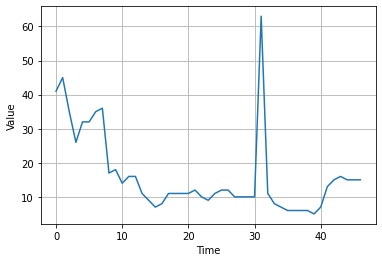

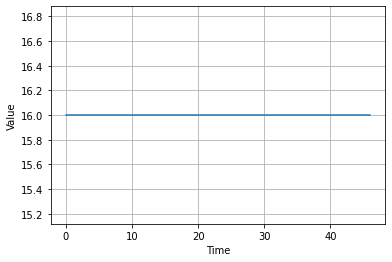

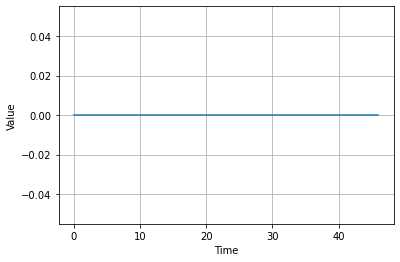

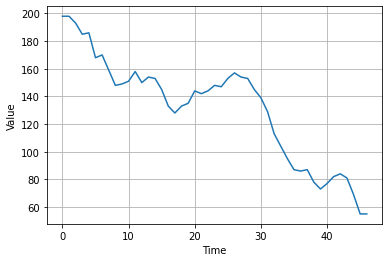

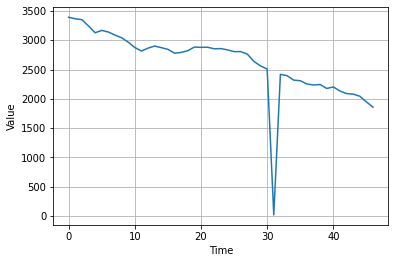

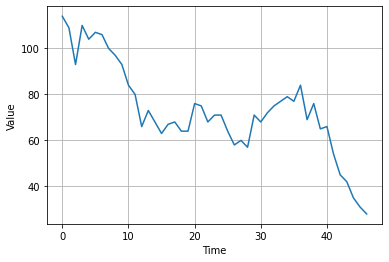

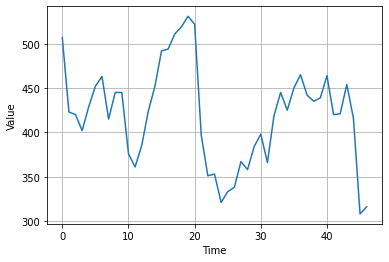

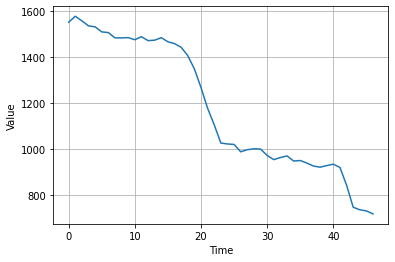

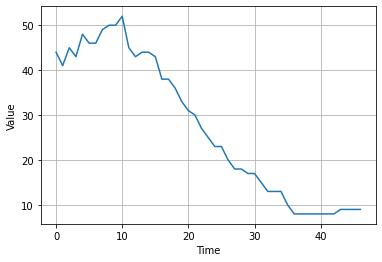

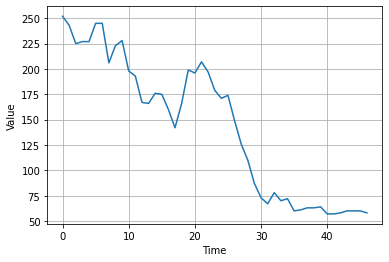

In [ ]:
def plot_series(series, days,format="-", start=0, end=None):
    plt.plot(np.arange(days), series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
for i in range(10):
  plt.figure()
  plot_series(data[3,-47:,int(random.uniform(0, 730))],47)

#Window the dataset

In [ ]:
batch_size = 32
shuffle_buffer_size = 1000
traindays=300
num_of_districts=736
window_size=10

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer,test):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 2))
  if test : dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  else: 
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  return dataset
  
test=data2[traindays:,:,:]
data2=data2[:traindays,:,:]
X,Y=[],[]
for dist in range(num_of_districts):
  temp = data2[:,:,dist]
  dst = windowed_dataset(temp, window_size, 1, shuffle_buffer_size,False)
  for x,y in dst:
    X.append(x.numpy())
    Y.append(y.numpy())
X_test,Y_test=[],[]
for dist in range(num_of_districts):
  temp = test[:,:,dist]
  dst = windowed_dataset(temp, window_size, 1, shuffle_buffer_size,True)
  for x,y in dst:
    X_test.append(x.numpy())
    Y_test.append(y.numpy())
X_train=np.squeeze(np.array(X))
Y_train=np.squeeze(np.array(Y))
X_test=np.squeeze(np.array(X_test))
Y_test=np.squeeze(np.array(Y_test))
print(X_test.shape,Y_test.shape)
print(X_train.shape,Y_train.shape)

(34592, 10, 5) (34592, 5)
(213440, 10, 5) (213440, 5)


#DO NOT OPEN below 6 cells

In [ ]:
# timesteps,input_dim=10,4
# peephole_lstm_cells = [tf.keras.experimental.PeepholeLSTMCell(size) for size in [0, 4]]
# # Create a layer composed sequentially of the peephole LSTM cells.
# layer = tf.keras.layers.RNN(peephole_lstm_cells)
# input = tf.keras.Input((timesteps, input_dim))
# output = layer(input)
# model=tf.keras.Model(input, output)
# model.compile(loss='mse',
#               optimizer='adam',
#               metrics=tf.keras.metrics.RootMeanSquaredError())
# history = model.fit( X,Y,batch_size=128,callbacks=[lr_schedule], epochs=40)

In [ ]:
import tensorflow as tf
num_features=4
OUT_STEPS=1

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    # self.lstm_cell = tf.keras.experimental.PeepholeLSTMCell(units)
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state
FeedBack.warmup = warmup
# prediction, state = feedback_model.warmup(multi_window.example[0])
# prediction.shape
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)
  # Insert the first prediction
  predictions.append(prediction)
  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)
  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions
FeedBack.call = call

In [ ]:
MAX_EPOCHS = 20
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
def compile_and_fit(model, X,Y,X_test,Y_test,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.keras.losses.MeanAbsolutePercentageError()])
  history = model.fit( X,Y, epochs=MAX_EPOCHS,
                      validation_data=(X_test,Y_test),
                      batch_size=128,callbacks=[lr_schedule]
                      # callbacks=[early_stopping]
                      )
  return history

In [ ]:
history = compile_and_fit(feedback_model, X,Y,X_test,Y_test,2)
IPython.display.clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/20
1668/1668 [==============================] - 27s 16ms/step - loss: 0.2713 - mean_absolute_percentage_error: 72164853.3301 - val_loss: 0.2832 - val_mean_absolute_percentage_error: 62850844.0000
Epoch 2/20
1668/1668 [==============================] - 26s 15ms/step - loss: 0.2712 - mean_absolute_percentage_error: 72351569.0449 - val_loss: 0.2832 - val_mean_absolute_percentage_error: 62860760.0000
Epoch 3/20
1668/1668 [==============================] - 26s 15ms/step - loss: 0.2705 - mean_absolute_percentage_error: 72288384.0911 - val_loss: 0.2830 - val_mean_absolute_percentage_error: 62871444.0000
Epoch 4/20
1668/1668 [==============================] - 26s 16ms/step - loss: 0.2710 - mean_absolute_percentage_error: 72271597.6273 - val_loss: 0.2829 - val_mean_absolute_percentage_error: 62883324.0000
Epoch 5/20
1668/1668 [==============================] - 26s 16ms/step - loss: 0.2708 - mean_absolute_percentage_error: 72386192.6806 - val_loss: 0.2827 - val_mean_absolute_percentage_e

NameError: ignored

In [ ]:
MAX_EPOCHS = 100
def compile_and_fit(model, X,Y,X_test,Y_test,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer='adam',
                metrics=[tf.keras.losses.MeanAbsolutePercentageError()])
  history = model.fit( X,Y, epochs=MAX_EPOCHS,
                      validation_data=(X_test,Y_test),
                      batch_size=128,callbacks=[lr_schedule]
                      # callbacks=[early_stopping]
                      )
  return history
history = compile_and_fit(feedback_model, X,Y,X_test,Y_test,2)
IPython.display.clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#TILL HERE
__________________________

# Active cases and district id as X features, Y is active cases

In [ ]:
X_temptrain=X_train[:,:,[3,4]]
Y_temptrain=Y_train[:,3]
Y_temptest=Y_test[:,3]
X_temptest=X_test[:,:,[3,4]]
print(np.array(X_temptest).shape,np.array(Y_temptest).shape)
print(np.array(X_temptrain).shape,np.array(Y_temptrain).shape)

(34592, 10, 2) (34592,)
(213440, 10, 2) (213440,)


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1)
])
def mean_absolute_percentage_error2(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
for epochno in range(10):
  print("Epoch number: {}".format(epochno))
  model.compile(loss=tf.keras.losses.Huber(),optimizer='adam'
                ,metrics=[tf.keras.losses.MeanAbsolutePercentageError()],run_eagerly=True)
  model.fit(X_temptrain,Y_temptrain,batch_size=128, epochs=1)
  model.save_weights("weights-{}.h5".format(epochno))
  predictions=model.predict(X_temptest)
  print('Performance on test data: ',mean_absolute_percentage_error2(scaler.inverse_transform(predictions.reshape(-1,1)),
                                          scaler.inverse_transform(Y_temptest.reshape(-1,1))))

#Loading best weights

In [ ]:
!gdown --id 1xeI4n0qsn5K5g8ElnrVlx7NefvwG812K
model.load_weights('/content/weights-9.h5')

#Evaluating on unscaled data

In [ ]:
predictions=model.predict(X_temptest)
Y_temptest_rs=Y_temptest.reshape(-1,47)
predictions_rs=predictions.reshape(-1,47)
print(Y_temptest_rs.shape,predictions_rs.shape)
mean_absolute_percentage_error2(scaler.inverse_transform(predictions_rs.reshape(-1,1)),
                                          scaler.inverse_transform(Y_temptest_rs.reshape(-1,1)))

(736, 47) (736, 47)


14.421154144788852

#Visualizing plots

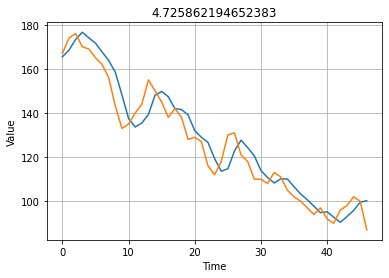

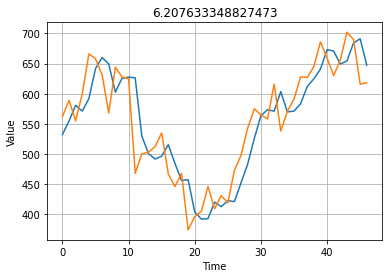

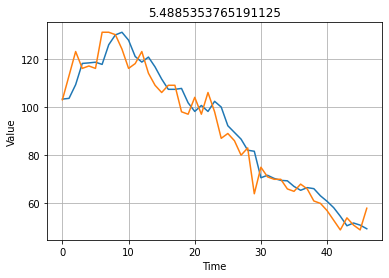

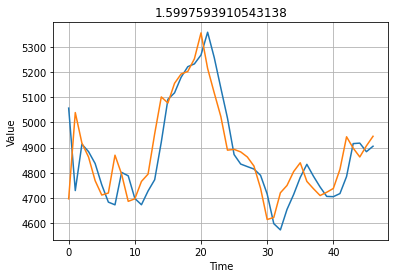

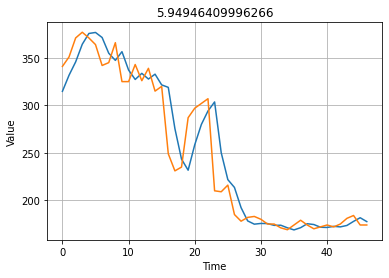

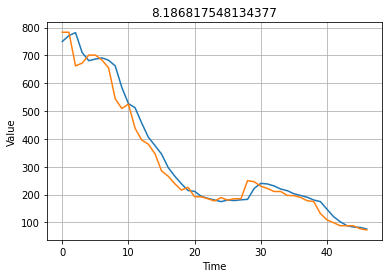

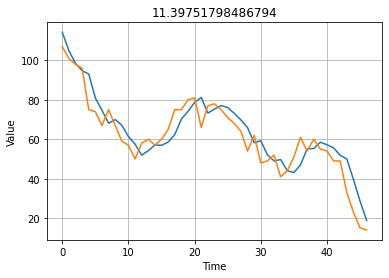

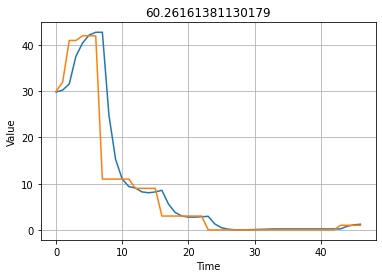

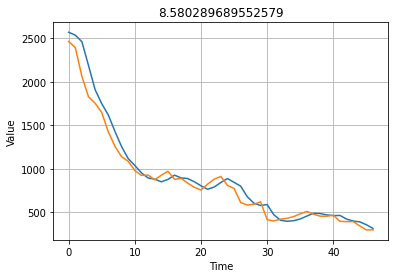

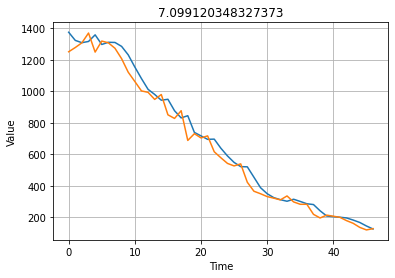

In [ ]:
for dist in range(10):
  dist=int(random.uniform(0,736))
  plt.figure()
  plot_series(scaler.inverse_transform(predictions_rs[dist,:].reshape(-1,1)),47)
  plot_series(scaler.inverse_transform(Y_temptest_rs[dist,:].reshape(-1,1)),47)
  plt.title(str(mean_absolute_percentage_error2(scaler.inverse_transform(predictions_rs[dist,:].reshape(-1,1)),
                                          scaler.inverse_transform(Y_temptest_rs[dist,:].reshape(-1,1)))))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
l=[]

for dist in range(736):
  l.append(mean_absolute_percentage_error(scaler.inverse_transform(predictions_rs[dist,:].reshape(-1,1)),
                                          scaler.inverse_transform(Y_temptest_rs[dist,:].reshape(-1,1))))
np.sort(np.array(l).astype(int))

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   

In [ ]:
print(scaler.inverse_transform(Y_temptest.reshape(-1,1)).shape,
      scaler.inverse_transform(X_temptest.reshape(-1,1)).shape)

(34592, 1) (691840, 1)


In [ ]:
mean_absolute_percentage_error(scaler.inverse_transform(predictions_rs.reshape(-1,1)),
                                          scaler.inverse_transform(Y_temptest_rs.reshape(-1,1)))

19.652938655829022

In [ ]:
34592/736

In [ ]:
# plt.figure()
# plt.hist(l,100)

In [ ]:
lt=[]
for i,j in enumerate(np.array(l).astype('int')):
  if j<=100: 
    lt.append(i)
print(np.sort(np.array(l)).astype(int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

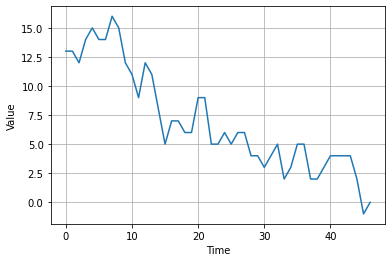

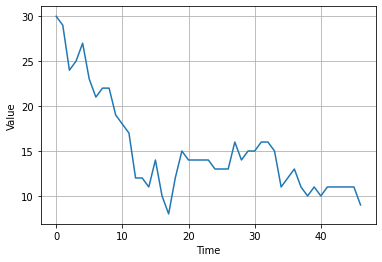

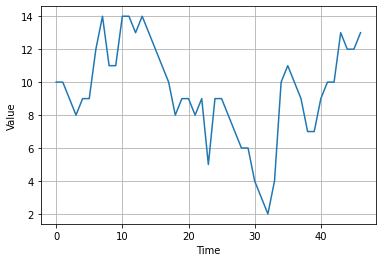

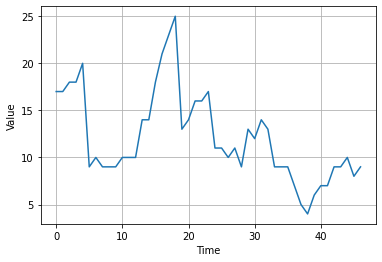

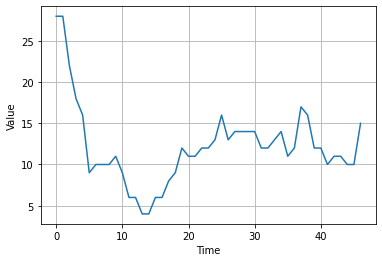

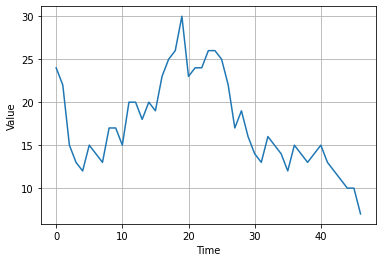

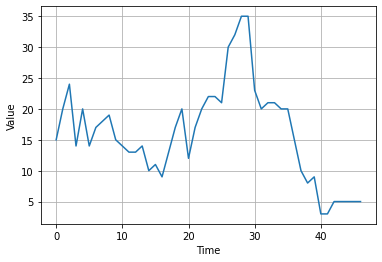

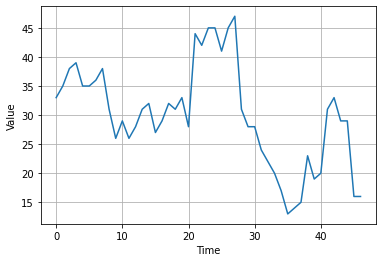

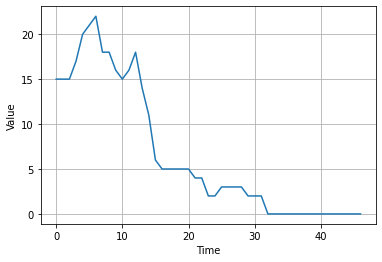

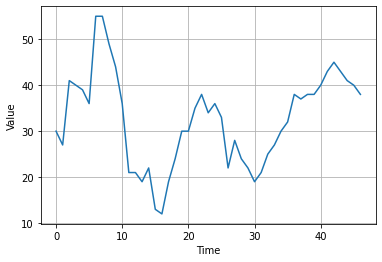

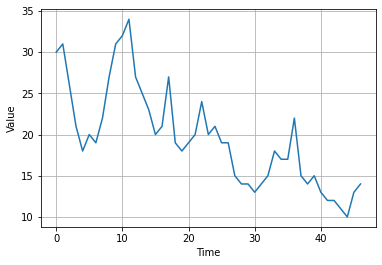

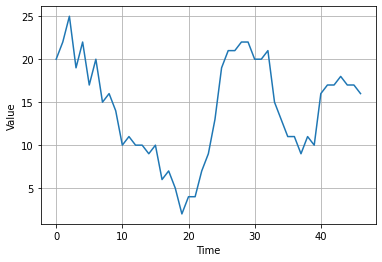

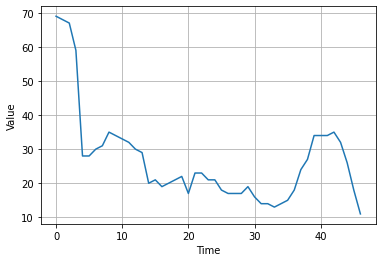

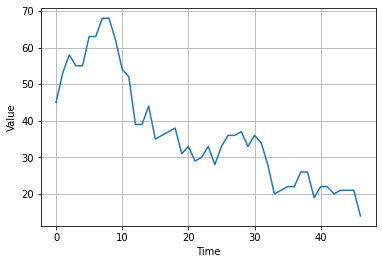

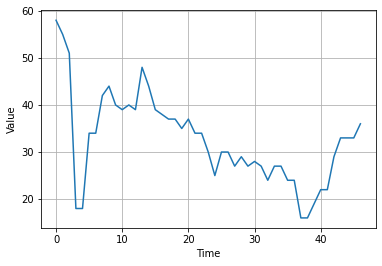

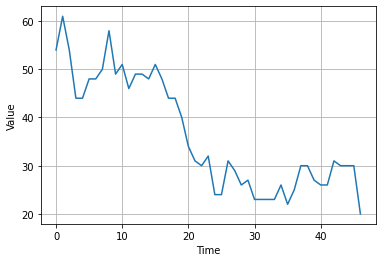

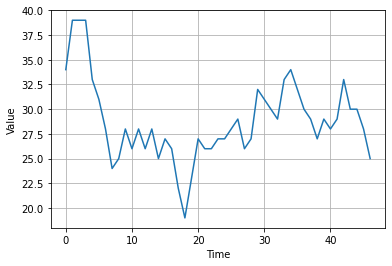

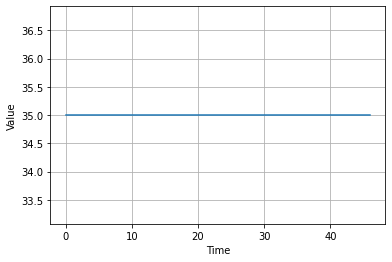

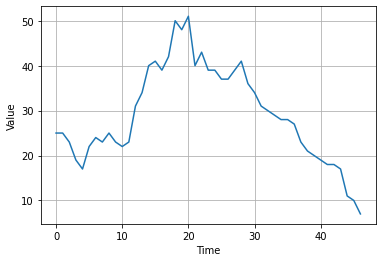

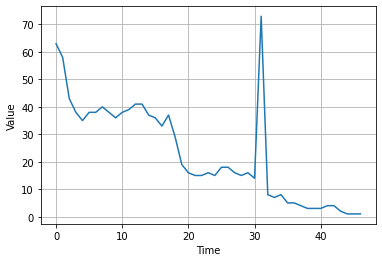

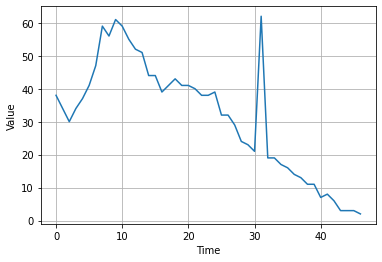

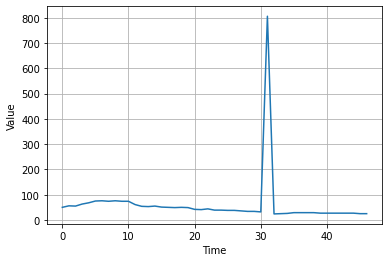

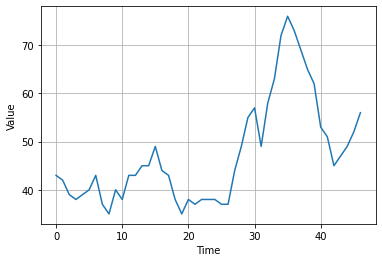

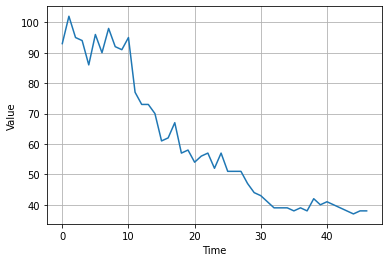

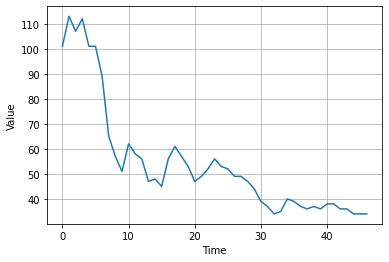

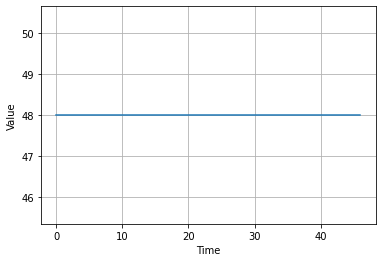

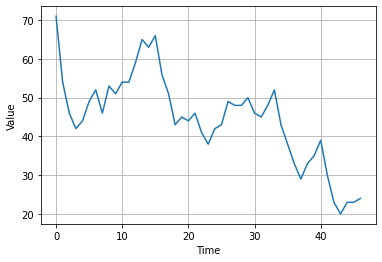

In [ ]:
for i in lt:
  plt.figure()
  plot_series(data[3,-47:,i],47)
# lt

In [ ]:
np.min(np.array(l))

6.326412067944453

In [ ]:
for i in lt:
  plot_series(scaler.inverse_transform(Y_temptest.reshape(-1,1))[:47],47)

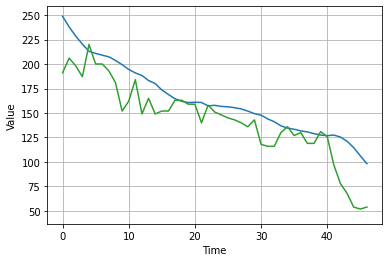

In [ ]:
predictions=model.predict(X_temptest)
for i in range()
plt.figure()
plot_series(scaler.inverse_transform(predictions)[:47],47)
plot_series(scaler.inverse_transform(Y_temptest.reshape(-1,1))[:47],47)

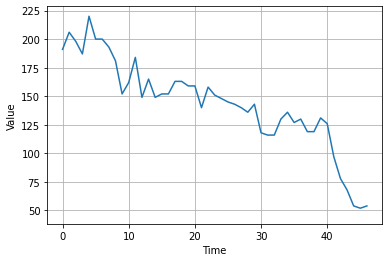

In [ ]:
# plot_series(data[0,-47:,0],47)
# plot_series(scaler.inverse_transform(predictions)[:47],47)
plot_series(scaler.inverse_transform(Y_temptest.reshape(-1,1))[:47],47)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(scaler.inverse_transform(Y_temptest.reshape(-1,1))[:47], scaler.inverse_transform(predictions)[:47])

ImportError: ignored

## 2 layer bidirectional LSTM 

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# model = tf.keras.models.Sequential([
#   # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#   #                     input_shape=[None]),
#   # tf.keras.layers.LayerNormalization( ),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#   tf.keras.layers.Dense(4 )
#   # tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])
# # lr_schedule = tf.keras.callbacks.LearningRateScheduler(   
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=[tf.keras.losses.MeanAbsolutePercentageError()])
history = model.fit(X,Y,batch_size=128,callbacks=[lr_schedule], epochs=10, validation_data=(X_test,Y_test))


Epoch 1/10
1668/1668 [==============================] - 19s 9ms/step - loss: 0.0017 - mean_absolute_percentage_error: 91.6244 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 20.7352
Epoch 2/10
1668/1668 [==============================] - 14s 8ms/step - loss: 0.0016 - mean_absolute_percentage_error: 44.3798 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 20.2260
Epoch 3/10
1668/1668 [==============================] - 14s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 203.5130 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 19.5963
Epoch 4/10
1668/1668 [==============================] - 14s 8ms/step - loss: 0.0014 - mean_absolute_percentage_error: 92.5240 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 18.9039
Epoch 5/10
1668/1668 [==============================] - 13s 8ms/step - loss: 0.0013 - mean_absolute_percentage_error: 305.5628 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 18.1724
Epoch 6/10
1668/1668 [=====================

In [ ]:
X_temptrain=X_train[:,:,[3,4]]
Y_temptrain=Y_train[:,3]
Y_temptest=Y_test[:,3]
X_temptest=X_test[:,:,[3,4]]
print(np.array(X_temptest).shape,np.array(Y_temptest).shape)
print(np.array(X_temptrain).shape,np.array(Y_temptrain).shape)

# Peephole lstm

In [ ]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)
# tf.keras.backend.clear_session()
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1)
# ])
# def mean_absolute_percentage_error2(y_true, y_pred): 
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# for epochno in range(10):
#   print("Epoch number: {}".format(epochno))
#   model.compile(loss=tf.keras.losses.Huber(),optimizer='adam'
#                 ,metrics=[tf.keras.losses.MeanAbsolutePercentageError()],run_eagerly=True)
#   model.fit(X_temptrain,Y_temptrain,batch_size=128, epochs=1)
#   model.save_weights("weights-{}.h5".format(epochno))
#   predictions=model.predict(X_temptest)
#   print('Performance on test data: ',mean_absolute_percentage_error2(scaler.inverse_transform(predictions.reshape(-1,1)),
#                                           scaler.inverse_transform(Y_temptest.reshape(-1,1))))
# E1D1
# n_features ==> no of features at each timestep in the data.
#
n_past,n_features,n_future=10,2,10
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 41200       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 10, 100)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 10, 100)      80400       repeat_vector[0][0]              
                                                                 lstm_1[0][1]                 

In [ ]:
X_temptrain=X_train[:,:,[3,4]]
Y_temptrain=Y_train[:,3]
Y_temptest=Y_test[:,3]
X_temptest=X_test[:,:,[3,4]]
print(np.array(X_temptest).shape,np.array(Y_temptest).shape)
print(np.array(X_temptrain).shape,np.array(Y_temptrain).shape)

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.RNN( tfa.rnn.PeepholeLSTMCell(32),return_sequences=True),
  tf.keras.layers.RNN( tfa.rnn.PeepholeLSTMCell(32)),
  tf.keras.layers.Dense(4)
  # tf.keras.layers.Lambda(lambda x: x * 100.0)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=[tf.keras.losses.MeanAbsolutePercentageError()])
history = model.fit( X_temptrain,Y_temptrain,batch_size=128,callbacks=[lr_schedule], epochs=100, validation_data=(X_temptest,Y_temptest))

Epoch 1/100
1668/1668 [==============================] - 81s 47ms/step - loss: 0.0220 - mean_absolute_percentage_error: 109.2118 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 108.9127
Epoch 2/100
1668/1668 [==============================] - 80s 48ms/step - loss: 0.0219 - mean_absolute_percentage_error: 109.1149 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 108.8106
Epoch 3/100
1668/1668 [==============================] - 79s 47ms/step - loss: 0.0219 - mean_absolute_percentage_error: 109.0047 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 108.6970
Epoch 4/100
1668/1668 [==============================] - 79s 47ms/step - loss: 0.0218 - mean_absolute_percentage_error: 108.8824 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 108.5719
Epoch 5/100
1668/1668 [==============================] - 78s 47ms/step - loss: 0.0218 - mean_absolute_percentage_error: 108.7477 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 108.4327
Epoch 6/100
1668/1668 [==

(1e-08, 0.0001, 0.0, 30.0)

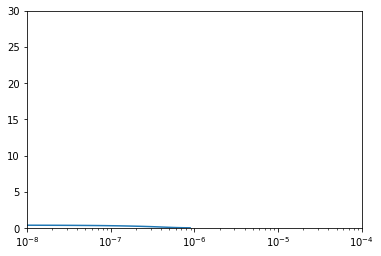

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

In [ ]:
test.shape

(57, 4, 736)

In [ ]:
model.predict(test[:10,:,0][np.newaxis])

array([[ 0.87637   , -0.00278196,  0.77160233,  0.19020642]],
      dtype=float32)

In [ ]:
series = np.concatenate((test,data2),axis=0)
print(test.shape, data2.shape, series.shape)

(57, 4, 736) (300, 4, 736) (357, 4, 736)


In [ ]:
Y_pred=model.predict(Xtester)
loss = np.mean(np.square(Ytester - Y_pred), axis=0)
loss

array([0.01347162, 0.00049403, 0.04066938, 0.03636982])

In [ ]:
print(Ytester.shape,Y_pred.shape)

(34592, 4) (34592, 4)


In [ ]:
Xtester=[]
Ytester=[]
forecast = []
results = []
for time in range(0,47):
  for dist in range(736):
    Xtester.append(test[time:time+10,:,dist])
    Ytester.append(test[time+10, :,dist])
# forecast = forecast[split_time-window_size:]
# resultsplot_series = np.array(forecast)[:, 0, 0]
# plt.figure(figsize=(10, 6))
# (time_valid, x_valid)
# plot_series(time_valid, results)
Xtester=np.array(Xtester)
Ytester=np.array(Ytester)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.514286

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

KeyError: ignored

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)